In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

import os
import sys
from pathlib import Path
from pprint import pprint
import pickle
from scipy.optimize import curve_fit

from utils import analysis, utils, files # sibling package...

- Subject
- Task
  - Session -- three of these
    - 1,2,3
  - Block -- there should be 15 of these per session
    - session
  - Trial -- there should be 12 of these per block
    - session num
    - block num
    - subject 
    - outcome (hit, miss, nohold)
    - emg (64xS)
    - counter (1xS)
    - behavior (2xF)
    - target x,y idx
    - time to outcome
    - num_holds?
        
- grab this data and build behavior matrix
  - x,y,xdot,ydot,xdotdot,ydotdot, trial, target x TxN

for each task

get every trial
note its session
for data, just store the data's path

for subject
for center hold
get every trial


In [47]:
experiment = "emg_olympics"
subject = "alba"
task = "center_hold"
session = 0
block = 0
trial = 0

data folder:  /Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/emg_olympics
0
/Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/emg_olympics/alba/center_hold/session_0/0_emg_2021-09-21T13_23_18.bin


In [ ]:

def get_task_paths(subject_folder):
    task_paths = {}
    for x in subject_folder.iterdir(): 
        if x.name[0] != ".":
            task_paths[x.name] = x
    return task_paths

def get_outcome_path(block_path):
    return [x for x in block_path.iterdir() if "result" in x.name][0]

class Trial():
    def __init__(self):
        self.target_coordinate = None
        self.outcome = None
        self.hold_time = None
        self.reach_time = None
        
        self.idx = None
        self.target_idx = None
        self.session = None
        self.behavior_path = None # self.get_behavior_path()
        self.emg_path = None # self.get_signal_path()
        
    def parse_outcome(self, outcome):
        self.target_coordinate = outcome["target"]
        
        self.outcome = outcome["outcome"]
        self.hold_time = outcome["hold_time"]
        self.reach_time = outcome["reach_time"]

    def parse_target(self, coord):
        for idx, t in enumerate(self.targets):
            if sum(abs(coord - t)) < 0.001:
                return idx

class Block():
    def __init__(self,path):
        self.path = path
        self.outcomes = self.get_outcomes()
        self.trials = self.add_trials()
        self.idx = int(path.name.split("_")[-1])
        print(self.idx)
        self.add_paths_to_trials()
        
    def get_outcomes(self):
        outcome_path = get_outcome_path(self.path)
        # get something we can index
        #  outcome, HT, RT, tX, tY
        behavior = np.genfromtxt(str(outcome_path), delimiter=',', skip_header=1, dtype=None, encoding=None)
        outcome_dict = {}
        for i, x in enumerate(behavior):
            outcome_dict[str(i)] = {}
            outcome_dict[str(i)]["outcome"] = x[0]
            outcome_dict[str(i)]["target"] = [x[-2],x[-1]]
            outcome_dict[str(i)]["hold_time"] = x[1]
            if x[0] == "Hit":
                outcome_dict[str(i)]["reach_time"] = x[2]
            else:
                outcome_dict[str(i)]["reach_time"] = None
        return outcome_dict
        
    def add_trials(self):
        trials = []
        for _, outcome in self.outcomes.items(): # trial_path, trial_outcome in b.outcomes:
            trial = Trial()
            trial.parse_outcome(outcome)
            trials.append(trial)
        return trials

    def add_paths_to_trials(self):
        emg_paths = sorted([x for x in self.path.iterdir() if "emg" in x.name and "filtered" not in x.name and x.suffix == ".bin"], key=files.parse_filename_prefix)
        filtered_paths = sorted([x for x in self.path.iterdir() if "emg" in x.name and "filtered" in x.name and x.suffix == ".bin"], key=files.parse_filename_prefix)
        behavior_paths = sorted([x for x in self.path.iterdir() if "behavior" in x.name and x.suffix == ".csv"], key=files.parse_filename_prefix)
        assert len(emg_paths) == len(self.trials), "mismatch between number of trials and number of paths"
        assert len(filtered_paths) == len(self.trials), "mismatch between number of trials and number of paths"
        assert len(behavior_paths) == len(self.trials), "mismatch between number of trials and number of paths"
        for emg_path, filtered_path, behavior_path, trial in zip(emg_paths, filtered_paths, behavior_paths, self.trials):
            trial.emg_path = emg_path
            trial.filtered_path = filtered_path
            trial.behavior_path = behavior_path

In [66]:

subject_metadata_folder = utils.get_subject_folder(experiment,subject)
experiment_data_folder = utils.get_experiment_data_folder(experiment)
subject_data_folder = experiment_data_folder / subject

sorted_block_paths = sorted([x for x in (subject_data_folder / task).iterdir() if x.name[0] != "." and "session" in x.name], key=lambda x: int(x.name.split("_")[-1]))
block_path = sorted_block_paths[block+2]

b = Block(block_path)

data folder:  /Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/emg_olympics
2


In [77]:
np.bincount()

3


/Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/emg_olympics/alba/center_hold/session_2/0_emg_2021-09-21T13_26_42.bin
/Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/emg_olympics/alba/center_hold/session_2/0_behavior_2021-09-21T13_26_42.csv


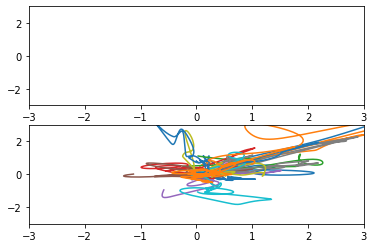

In [67]:

print(b.trials[0].emg_path)
print(b.trials[0].behavior_path)


def load_behavior(path):
    return np.genfromtxt(path, delimiter=',', skip_header=1, dtype=float, encoding=None)

fig, axes = plt.subplots(2,1)
for ax in axes:
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
for i in range(len(b.trials)):
    t = b.trials[i]
    behavior = load_behavior(t.behavior_path)
    if t.outcome == "No Hold":
        axes[0].plot(behavior[:,-2],behavior[:,-1])
    else:
        axes[1].plot(behavior[:,-2],behavior[:,-1])
# print(utils.load_center_hold_emg(block_path))
# sorted_emg_paths = sorted([x for x in block_path.iterdir() if x.name[0] != "." and "session" in x.name], key=lambda x: int(x.name.split("_")[-1]))

# behavior

In [5]:
# behavior = []
# for session_path in get_session_path_list("bob"):
#     session_behavior = {}
#     trial_paths = [trial_path for trial_path in session_path.iterdir() if "behavior" in trial_path.name]
#     for trial in trial_paths:
#         session_no, target_ 
#         behavior_array = np.genfromtxt(str(trial), delimiter=',', skip_header=1, dtype=np.float, encoding=None)
        
#         session_behavior[] = behavior_array

#     behavior.append(session_behavior)

class Subject():
    def __init__(self):
        self.sessions = []

class Session():
    def __init__(self):
        self.trials = []
        self.number = None




